Using the classic 1978 Housing Prices Dataset:

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm
import copy
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data preparation

Load data

In [3]:
housing_df = pd.read_csv('./data/Housing.csv')

In [4]:
housing_df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
housing_df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [6]:
housing_df.shape

(545, 13)

Rewriting dataframes so that types are compatbile with numpy and torch

In [7]:
housing_df['price'] = housing_df['price'].astype(np.float32)
housing_df['area'] = housing_df['area'].astype(np.float32)
housing_df['bedrooms'] = housing_df['bedrooms'].astype(np.float32)
housing_df['bathrooms'] = housing_df['bathrooms'].astype(np.float32)
housing_df['stories'] = housing_df['stories'].astype(np.float32)
housing_df['parking'] = housing_df['parking'].astype(np.float32)

In [8]:
mapping_fun = {'no': -1.0, 'yes': 1.0}

housing_df['mainroad'] = housing_df['mainroad'].map(mapping_fun).astype(np.float32)
housing_df['guestroom'] = housing_df['guestroom'].map(mapping_fun).astype(np.float32)
housing_df['basement'] = housing_df['basement'].map(mapping_fun).astype(np.float32)
housing_df['hotwaterheating'] = housing_df['hotwaterheating'].map(mapping_fun).astype(np.float32)
housing_df['airconditioning'] = housing_df['airconditioning'].map(mapping_fun).astype(np.float32)
housing_df['prefarea'] = housing_df['prefarea'].map(mapping_fun).astype(np.float32)

In [9]:
mapping_furnishing_fun = {'unfurnished': -1.0, 'semi-furnished': 0.0, 'furnished': 1.0}

housing_df['furnishingstatus'] = housing_df['furnishingstatus'].map(mapping_furnishing_fun).astype(np.float32)

In [10]:
housing_df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000.0,7420.0,4.0,2.0,3.0,1.0,-1.0,-1.0,-1.0,1.0,2.0,1.0,1.0
1,12250000.0,8960.0,4.0,4.0,4.0,1.0,-1.0,-1.0,-1.0,1.0,3.0,-1.0,1.0
2,12250000.0,9960.0,3.0,2.0,2.0,1.0,-1.0,1.0,-1.0,-1.0,2.0,1.0,0.0
3,12215000.0,7500.0,4.0,2.0,2.0,1.0,-1.0,1.0,-1.0,1.0,3.0,1.0,1.0
4,11410000.0,7420.0,4.0,1.0,2.0,1.0,1.0,1.0,-1.0,1.0,2.0,-1.0,1.0


In [11]:
housing_df.dtypes

price               float32
area                float32
bedrooms            float32
bathrooms           float32
stories             float32
mainroad            float32
guestroom           float32
basement            float32
hotwaterheating     float32
airconditioning     float32
parking             float32
prefarea            float32
furnishingstatus    float32
dtype: object

In [12]:
housing_df.shape

(545, 13)

Split data into test and train datasets

In [13]:
X_train_raw_df, X_test_raw_df, y_train_df, y_test_df = train_test_split(housing_df.drop('price', axis=1), housing_df['price'], train_size=0.7, shuffle=True)

Standardize the data

In [14]:
std_scaler = StandardScaler()
std_scaler.fit(X_train_raw_df)

X_train_df = std_scaler.transform(X_train_raw_df)
X_test_df = std_scaler.transform(X_test_raw_df)

## Model preparation

In [15]:
model = nn.Sequential(
    nn.Linear(12, 32),
    nn.ReLU(),
    nn.Linear(32, 24),
    nn.ReLU(),
    nn.Linear(24, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

model.to(device)

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
)

Loss function and optimizer

In [16]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Build tensors

In [17]:
X_train_tensor = torch.tensor(X_train_df, device=device)
y_train_tensor = torch.tensor(y_train_df.values, device=device).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_df, device=device)
y_test_tensor = torch.tensor(y_test_df.values, device=device).reshape(-1, 1)

## Model training

In [18]:
n_epochs = 10_000   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)

Remember the best model

In [19]:
best_mse = np.inf   # init to infinity
best_weights = None
history = []

Training loop

In [20]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

MSE: 1319274283008.00
RMSE: 1148596.66


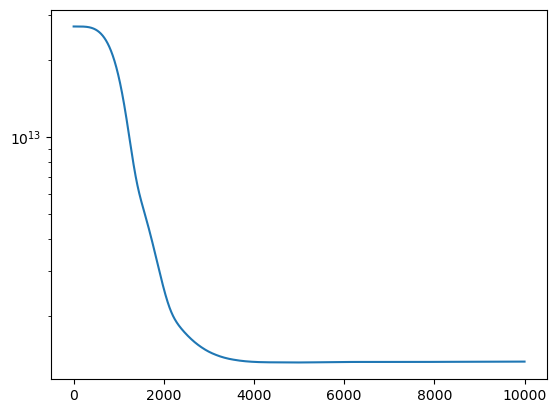

In [21]:
model.load_state_dict(best_weights)

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.yscale('log')
plt.show()

## Save results

In [22]:
torch.save(model, './model/model.pt')

I also have to save the `StandardScaler` in order to apply the same transformation for new data

In [23]:
with open("./model/std_scaler.pickle","wb") as file:
    pickle.dump(std_scaler, file)

## Save test data

In [24]:
with open("./data/X_test_raw_df.pickle","wb") as file:
    pickle.dump(X_test_raw_df, file)

with open("./data/y_test_df.pickle","wb") as file:
    pickle.dump(X_test_raw_df, file)